In [1]:
# %conda init
# %conda deactivate
# %conda env remove --name dql --yes
# %conda env create -f ../requirements.yaml
%conda env update -f ../requirements.yaml
# %pip install git+https://github.com/yhilpisch/tpqoa.git

xonsh: For full traceback set: $XONSH_SHOW_TRACEBACK = True
RuntimeError: attempting to source non-xonsh file! If you are trying to source a file in another language, then please use the appropriate source command. For example, source-bash script.sh
Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



hdf5-1.14.3          | 3.6 MB    |                                       |   0% 
openssl-3.3.0        | 2.4 MB    |                                       |   0% 
hdf5-1.14.3          | 3.6 MB    | 1                                     |   0% 
hdf5-1.14.3          | 3.6 MB    | ####                                  |  11% 
openssl-3.3.0        | 2.4 MB    | ############8                         |  35% 
hdf5-1.14.3          | 3.6 MB    |

In [2]:
import tpqoa
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use ('seaborn-v0_8')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# The Data

## EOD Data

In [4]:
fl = 'http://hilpisch.com/tr_eikon_eod_data.csv'
raw = pd.read_csv(fl, index_col=0, parse_dates=True).dropna()
raw.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [5]:
data_ = pd.DataFrame(raw['EUR='])

## Intraday Data

In [6]:
symbol = 'EUR_USD' 
start = '2019-02-01'
end = '2019-03-31'
granularity = 'M30' 
price = 'A'
fn = f'../data/oanda_{symbol}_{start}_{end}_{granularity}_{price}.csv'
fn

'../data/oanda_EUR_USD_2019-02-01_2019-03-31_M30_A.csv'

In [7]:
%%time
try:
  raw = pd.read_csv(fn, index_col=0, parse_dates=True) 
except:
  api = tpqoa.tpqoa('../oanda.cfg' )
  raw = api.get_history(symbol, start, end, granularity, price)
  raw.to_csv(fn)

CPU times: user 8.98 ms, sys: 2.62 ms, total: 11.6 ms
Wall time: 9.89 ms


In [8]:
data = pd.DataFrame (raw['c'])

In [9]:
data_['r'] = np.log (data_ / data_.shift())
data_.dropna(inplace=True)

data.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1964 entries, 2019-02-01 00:00:00 to 2019-03-29 20:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c       1964 non-null   float64
dtypes: float64(1)
memory usage: 30.7 KB


# Time Series Features

In [10]:
from tsfresh import extract_features 
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

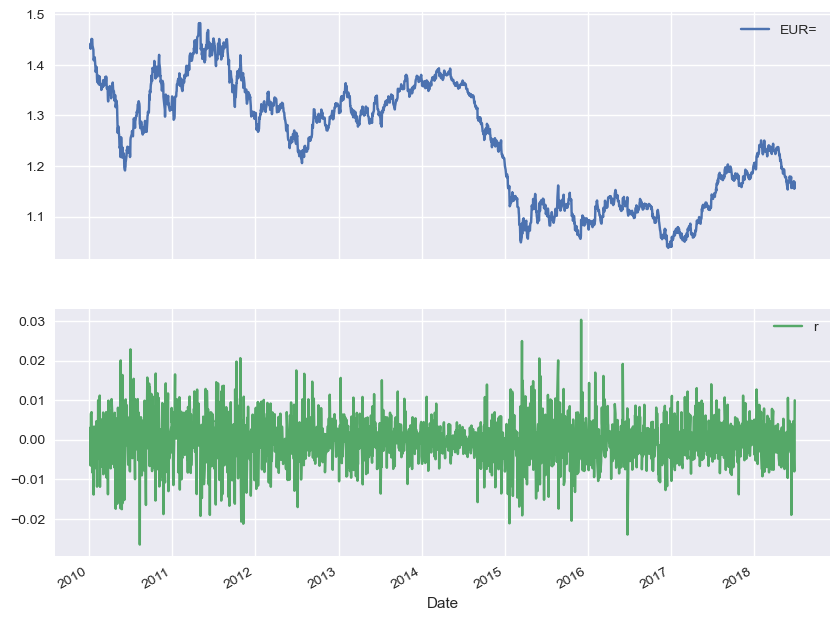

In [11]:
n = 0
data_.iloc[-n:].plot(subplots=True, figsize=(10, 8));

In [12]:
basis, labels = make_forecasting_frame(
                    data_.iloc[-n:, 1],
                    kind='return',
                    max_timeshift=5,
                    rolling_direction=1
                )

Rolling: 100%|██████████| 40/40 [00:05<00:00,  7.42it/s]


In [13]:
basis.sort_values('time').head(10)

labels.head()

%time
data = extract_features(basis,
              column_id='id',
              column_sort='time',
              column_value= 'value',
              impute_function=impute,
              show_warnings=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


Feature Extraction: 100%|██████████| 40/40 [01:06<00:00,  1.66s/it]


Now we see that tsfresh has added a long list of timeseries-related features.

In [14]:
data.head()

value__variance_larger_than_standard_deviation  \
id 2010-01-06                                             0.0   
   2010-01-07                                             0.0   
   2010-01-08                                             0.0   
   2010-01-11                                             0.0   
   2010-01-12                                             0.0   

               value__has_duplicate_max  value__has_duplicate_min  \
id 2010-01-06                       0.0                       0.0   
   2010-01-07                       0.0                       0.0   
   2010-01-08                       0.0                       0.0   
   2010-01-11                       0.0                       0.0   
   2010-01-12                       0.0                       0.0   

               value__has_duplicate  value__sum_values  value__abs_energy  \
id 2010-01-06                   0.0          -0.002988           0.000009   
   2010-01-07                   0.0           0.000069           0.000018   
   2010-01-08                   0.0          -0.006474           0.000061   
   2010-01-11                   0.0           0.000069           0.000104   
   2010-01-12                   0.0           0.007053           0.000153   

               value__mean_abs_change  value__mean_change  \
id 2010-01-06                0.005840           -0.000005   
   2010-01-07                0.006046            0.006046   
   2010-01-08                0.007824           -0.001778   
   2010-01-11                0.009578            0.003177   
   2010-01-12                0.007294            0.002493   

               value__mean_second_derivative_central  value__median  ...  \
id 2010-01-06                              -0.000053      -0.002988  ...   
   2010-01-07                              -0.000053       0.000035  ...   
   2010-01-08                              -0.007824      -0.002988  ...   
   2010-01-11                               0.001760       0.000035  ...   
   2010-01-12                              -0.000934       0.003058  ...   

               value__fourier_entropy__bins_5  \
id 2010-01-06                        1.098612   
   2010-01-07                       -0.000000   
   2010-01-08                        0.693147   
   2010-01-11                        1.098612   
   2010-01-12                        1.098612   

               value__fourier_entropy__bins_10  \
id 2010-01-06                         1.098612   
   2010-01-07                        -0.000000   
   2010-01-08                         0.693147   
   2010-01-11                         1.098612   
   2010-01-12                         1.098612   

               value__fourier_entropy__bins_100  \
id 2010-01-06                          1.098612   
   2010-01-07                         -0.000000   
   2010-01-08                          0.693147   
   2010-01-11                          1.098612   
   2010-01-12                          1.098612   

               value__permutation_entropy__dimension_3__tau_1  \
id 2010-01-06                                        1.098612   
   2010-01-07                                        1.098612   
   2010-01-08                                       -0.000000   
   2010-01-11                                        0.693147   
   2010-01-12                                        1.098612   

               value__permutation_entropy__dimension_4__tau_1  \
id 2010-01-06                                        0.693147   
   2010-01-07                                        0.693147   
   2010-01-08                                        0.693147   
   2010-01-11                                       -0.000000   
   2010-01-12                                        0.693147   

               value__permutation_entropy__dimension_5__tau_1  \
id 2010-01-06                                             0.0   
   2010-01-07                                             0.0   
   2010-01-08                             

Add some columns to represent lags.

In [15]:
lags = 10
for lag in range(1, lags + 1):
  col = f'd_lag_{lag}'
  data[col] = np.sign(labels).shift(lag)

## Dropping Constant Values

Some of the values generated by tsfresh are redundant - i.e. all values in the column are the same number. So we drop these columns.

In [16]:
data.shape

(2136, 793)

In [17]:
data.apply(pd.Series.nunique).head(7)

data = data.loc[:, data.apply(pd.Series.nunique) != 1]

data.shape

(2136, 212)

In [18]:
# Adding Last Value

data['feature_last_value'] = labels.shift(1)

cols = data.columns

Now we drop the first line.

In [19]:
data = data.iloc[1:, ]
data['r'] = labels[1:]
data['d'] = np.where(labels > 0, 1, 0)[1:]

data. shape

(2135, 215)

## Normalization

In [20]:
split = int(len(data) * 0.6)
val_size = int(split * 0.15)
train = data.iloc[:split]

data[cols] = (data[cols] - train[cols].mean()) / train[cols].std()

data = impute(data)

## Train/Test Split

In [21]:
train = data.iloc[:split]
val = train[-val_size:]
train = train[:-val_size]
test = data.iloc[split:].copy()

# K Best Feature Selection

In [22]:
from sklearn. feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=25)

cols_sel = selector.fit(train[cols], train[ 'd']).get_support(indices=True)

cols_sel

csel = data.columns[cols_sel]
csel

Index(['value__median', 'value__longest_strike_above_mean',
       'value__cid_ce__normalize_True',
       'value__large_standard_deviation__r_0.45', 'value__quantile__q_0.3',
       'value__quantile__q_0.4', 'value__quantile__q_0.6',
       'value__quantile__q_0.7', 'value__autocorrelation__lag_1',
       'value__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'value__partial_autocorrelation__lag_1',
       'value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
       'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.4__ql_0.0',
       'value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
       '

# MLP Classifier

In [23]:
c = cols

from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(128, 128, 128),
                      learning_rate_init=0.02,
                      random_state=100,
                      max_iter=1000,
                      shuffle=False)

In [24]:
%time model.fit(train[c], train['d'])

CPU times: user 1min 39s, sys: 4.16 s, total: 1min 43s
Wall time: 10.9 s


MLPClassifier(hidden_layer_sizes=(128, 128, 128), learning_rate_init=0.02,
              max_iter=1000, random_state=100, shuffle=False)

In [25]:
pred = model.predict(test[c])
accuracy_score(test[ 'd'], pred)

0.5245901639344263

In [26]:
test['p'] = model.predict(test[c])
test['p'] = np.where(test['p'] > 0, 1, -1)

In [27]:
test['s'] = test['p'] * test['r']

test[[ 'r', 's']].sum().apply(np.exp)

sum(test['p'].diff() != 0)

test['p'].value_counts()

p
 1    428
-1    426
Name: count, dtype: int64

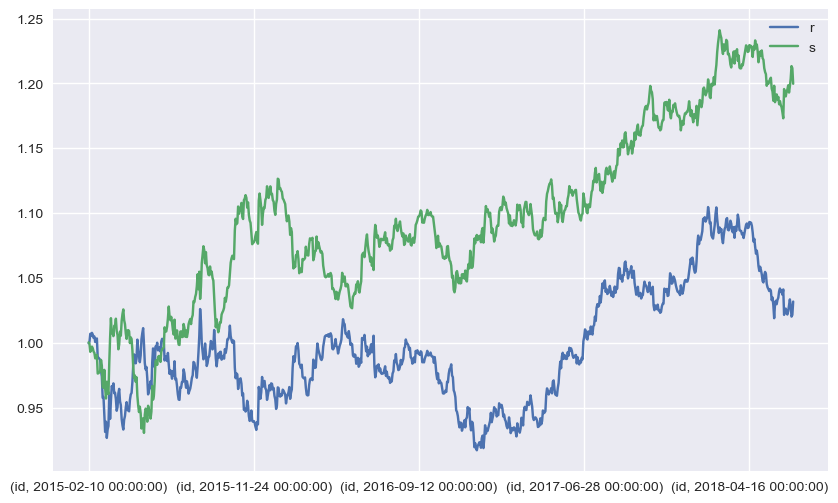

In [28]:
test[['r','s']] .cumsum().apply(np.exp).plot(figsize=(10, 6));

# Keras

In [29]:
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
from keras.models import Sequential
from keras.regularizers import l1, l2
from keras. layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

np.random.seed(100)
tf.random.set_seed(100)

c = cols

2024-05-08 19:36:30.522213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
model = Sequential()

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(len(c),)))
model.add(Dropout(0.3, seed=100))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001), ) )
model.add(Dropout(0.3, seed=100))
model.add(Dense(1, activation='sigmoid' ))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-05-08 19:36:56.885253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
callbacks = [ModelCheckpoint(filepath='weights.hdf5', 
                              monitor= 'val_acc',
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=True,
                              mode='auto',
                              period=1,
                        )]

In [32]:
%%time
model.fit(train[c], train['d'], epochs=250, batch_size=32, verbose=False, validation_data=(val[c], val['d']), shuffle=False, callbacks=callbacks)

CPU times: user 35.9 s, sys: 10.1 s, total: 46 s
Wall time: 30.7 s


In [33]:
res = pd. DataFrame(model.history.history)
res.tail(3)

,loss,accuracy,val_loss,val_accuracy
247,0.155559,0.982553,2.637191,0.468750
248,0.142766,0.986226,2.893185,0.468750
249,0.154704,0.983471,2.806988,0.453125


<Axes: >

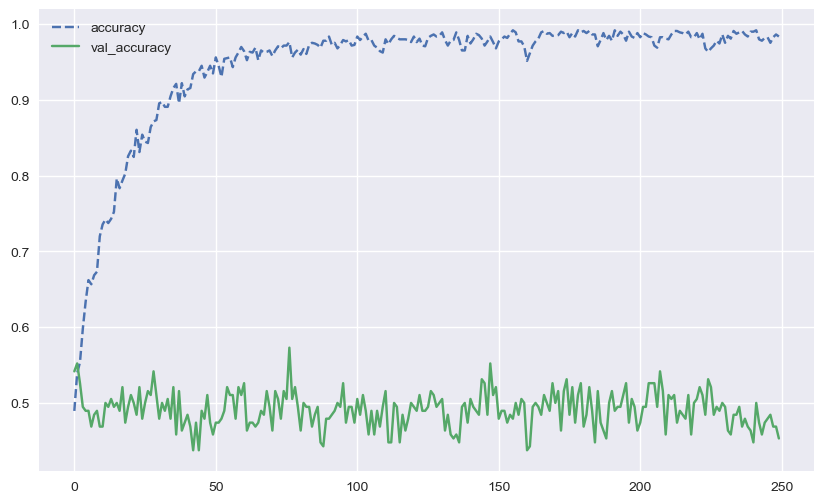

In [34]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style=['--'])

In [35]:
model.evaluate(test[c], test['d'])

27/27 [==============================] - 0s 1ms/step - loss: 2.3355 - accuracy: 0.5211


[2.3354992866516113, 0.5210772752761841]

In [36]:
model.predict(test[c])[:6]

27/27 [==============================] - 0s 1ms/step


array([[2.3232987e-07],
       [9.9290007e-01],
       [1.3825439e-07],
       [8.4121326e-05],
       [9.1692805e-01],
       [9.9963552e-01]], dtype=float32)

In [37]:
test['p'] = model.predict(test[c])
test['p'] = np.where(test['p'] > 0.5, 1, -1)

27/27 [==============================] - 0s 1ms/step


In [38]:
test[ 's' ] = test[ 'p'] * test['r']

# s gives the performance
test[['r', 's']].sum().apply(np.exp)



r    1.031794
s    1.158182
dtype: float64

In [39]:
# The number of trades
sum(test['p'].diff() != 0)

395

In [40]:
test['p'].value_counts()

p
 1    473
-1    381
Name: count, dtype: int64

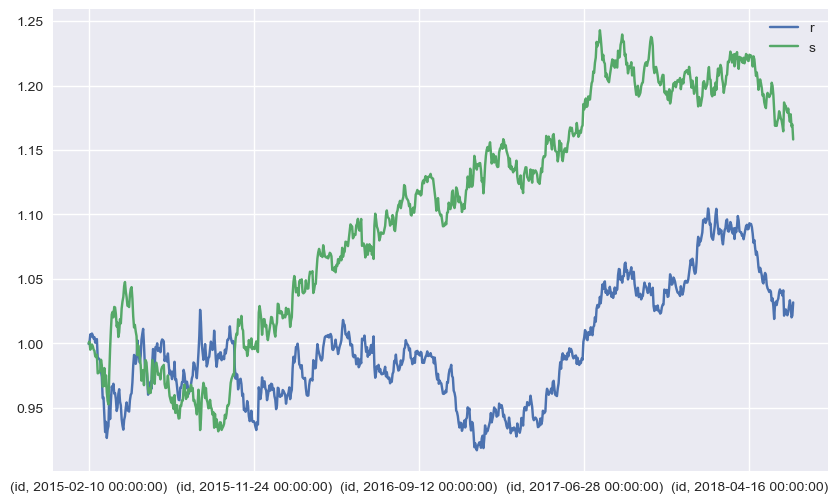

In [41]:
test[['r', 's' ]].cumsum().apply(np.exp).plot(figsize=(10, 6));